In [1]:
import datetime
import glob
import io
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import imageio
import PIL
import PIL.Image

from tensorflow.keras import layers

# todo: semi-supervised learning

- label cards with card type (land, instant, sorcery)
- label cards with set code (ZNR, M21)
- use these labels to teach D how to categorize cards

## increase training data

- load many more cards (how many expansions does it take to get to 10,000 cards?)

## discriminator

- improve discriminator model
    - D shouldnt be stupid, introduce label smooth instead (positive labels only)
        - currently implemented label smoothing, about to test
        - also added one more conv layer to D

In [2]:
IMG_HEIGHT = 204
IMG_WIDTH = 146

BUFFER_SIZE = 60000
BATCH_SIZE = 256

EPOCHS = 50

In [3]:
def get_card(path):
    card = PIL.Image.open(path)
    card = card.convert("L")
    card = np.asarray(card)
    
    return card

def get_cards(set_name):
    paths = glob.glob(f"./data/images/{set_name}/*.jpg")
    
    cards = np.asarray([get_card(path) for path in paths])
    cards = cards.reshape(cards.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')
    cards = (cards - 127.5) / 127.5
    
    return cards

In [4]:
card_images = get_cards("ZNR")
card_images.shape

(392, 204, 146, 1)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(card_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(51 * 36 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((51, 36, 256)))
    assert model.output_shape == (None, 51, 36, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 51, 36, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 102, 72, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 73 is a prime number, needed to do some tricky stuff to get the output width correct (146)
    model.add(layers.ZeroPadding2D(padding=((0, 0), (0, 1))))
    assert model.output_shape == (None, 102, 73, 64)
    
    # added two additional unconv layers
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 102, 73, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # here is the other one
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 102, 73, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
        
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, IMG_HEIGHT, IMG_WIDTH, 1)
        
    return model

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[IMG_HEIGHT, IMG_WIDTH, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # added additional conv layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

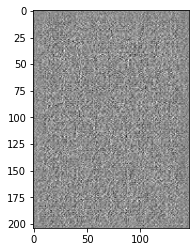

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[-4.7504578e-05]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output, alpha=0.1):
    # could try one sided label smoothed cost
    # 1s... - alpha (for example: alpha = 0.1)
    # only on positive labels (real_output)
    # instead of using just ones (from tf.ones_like)
    label_smoothed_cost = tf.constant(1.0 - alpha, dtype=tf.float32, shape=real_output.shape)
    
    real_loss = cross_entropy(label_smoothed_cost, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{current_time}"

summary_writer = tf.summary.create_file_writer(log_dir)

gen_loss_metric = tf.keras.metrics.Mean("gen_loss", dtype=tf.float32)
disc_loss_metric = tf.keras.metrics.Mean("disc_loss", dtype=tf.float32)

In [12]:
noise_dim = 100
cards_to_generate = 16

seed = tf.random.normal([cards_to_generate, noise_dim])

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gen_loss_metric(gen_loss)
    disc_loss_metric(disc_loss)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        plot = create_plot(generator, epoch, seed)
        image = plot_to_image(plot)
                                
        with summary_writer.as_default():
            tf.summary.scalar("gen_loss", gen_loss_metric.result(), step=epoch)
            tf.summary.scalar("disc_loss", disc_loss_metric.result(), step=epoch)
            tf.summary.image("Generator Output", image, step=epoch)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print("Epoch {}, Time Elapsed: {}, Generator Loss: {}, Discriminator Loss: {}".format(
            epoch + 1,
            time.time() - start,
            gen_loss_metric.result(),
            disc_loss_metric.result(),
        ))
        
        gen_loss_metric.reset_states()
        disc_loss_metric.reset_states()

In [15]:
def create_plot(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    
    # dont forget to adjust this if epochs > 4 digits
    plt.savefig("./sample_output/image_at_epoch_{:04d}.png".format(epoch))
    
    return fig

In [16]:
def plot_to_image(figure):
    buffer = io.BytesIO()
    
    plt.savefig(buffer, format="png")
    plt.close(figure)
    
    buffer.seek(0)
    image = tf.image.decode_png(buffer.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    
    return image

In [17]:
train(train_dataset, EPOCHS)

Epoch 1, Time Elapsed: 78.15420794487, Generator Loss: 0.6717647314071655, Discriminator Loss: 1.3652788400650024
Epoch 2, Time Elapsed: 66.54534006118774, Generator Loss: 0.6152299642562866, Discriminator Loss: 1.2920928001403809
Epoch 3, Time Elapsed: 68.6294059753418, Generator Loss: 0.6001231670379639, Discriminator Loss: 1.2395892143249512
Epoch 4, Time Elapsed: 67.10640001296997, Generator Loss: 0.6251800656318665, Discriminator Loss: 1.1869760751724243
Epoch 5, Time Elapsed: 71.31474494934082, Generator Loss: 0.80194491147995, Discriminator Loss: 1.0314520597457886
Epoch 6, Time Elapsed: 72.39305019378662, Generator Loss: 1.262862205505371, Discriminator Loss: 0.8128517866134644
Epoch 7, Time Elapsed: 66.07634091377258, Generator Loss: 1.7591893672943115, Discriminator Loss: 0.6846152544021606
Epoch 8, Time Elapsed: 69.5318591594696, Generator Loss: 1.7280256748199463, Discriminator Loss: 0.6938535571098328
Epoch 9, Time Elapsed: 72.17478203773499, Generator Loss: 1.320754766464